# Title of the Notebook
### Brief Description
Provide a summary of the notebook's purpose, such as implementing a mathematical model, running experiments, and analyzing results.


In [1]:
# ===============================
# 1. Setup
# ===============================

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig,inv,det
from math import pi
from cmath import exp, cos, sin,log

# Set random seed for reproducibility (if applicable)
np.random.seed(42)

# Log versions of important libraries for reproducibility
import importlib.metadata
print(f"Numpy version: {importlib.metadata.version('numpy')}")

Numpy version: 1.26.4


In [3]:
%watermark

UsageError: Line magic function `%watermark` not found.


## Section 2 - The model problem

**Check ellipticity**

Let us consider a touple of matrices and check their ellipticity

In [3]:
# Define the matrices
A_11 = np.array([[3, -0.3], [-0.3, 1.5]])
A_12 = np.array([[0, 0], [0, 0]])
A_22 = np.array([[3, 0.3], [0.3, 2]])

def is_symmetric(matrix):
    """Check if a matrix is symmetric."""
    return np.allclose(matrix, matrix.T)

def has_positive_eigenvalues(matrix):
    """Check if a matrix has positive eigenvalues using Cholesky decomposition."""
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

def check_elliptic(A_11, A_12, A_22, beta_range=(-10, 10), beta_steps=1000):
    """
    Check if the triplet of matrices defines an elliptic system.
    
    Args:
        A_11, A_12, A_22 (np.ndarray): The input matrices.
        beta_range (tuple): Range of beta values to check (min, max).
        beta_steps (int): Number of beta steps to check in the range.
    
    Returns:
        bool: True if the matrices define an elliptic system, False otherwise.
    """
    # Check symmetry and positive definiteness of A_11 and A_22
    if not (is_symmetric(A_11) and has_positive_eigenvalues(A_11)):
        print("A_11 is not positive definite.")
        return False

    if not (is_symmetric(A_12)):
        print("A_12 is not symmetric.")
        return False
        
    if not (is_symmetric(A_22) and has_positive_eigenvalues(A_22)):
        print("A_22 is not positive definite.")
        return False

    # Check the condition for A_11 + 2*beta*A_12 + beta^2*A_22
    betas = np.linspace(beta_range[0], beta_range[1], beta_steps)
    for beta in betas:
        A_beta = A_11 + 2 * beta * A_12 + beta**2 * A_22
        if not (has_positive_eigenvalues(A_beta)):
            print(f"The matrix polynomial is not positive definite for beta = {beta}.")
            return False
            
    return True

# Run the check
if check_elliptic(A_11, A_12, A_22):
    print("The touple is elliptic.")

The touple is elliptic.


## Section 3 - Analysis of the model problem without boundary conditions

**Monic reduction**

The following code calculates the monic reduction of an elliptic touple.

In [8]:
def compute_monic_reduction(A_11, A_12, A_22):
    """
    Compute the monic reduction of the tuple (A_11, A_12, A_22) after checking ellipticity.
    
    Args:
        A_11, A_12, A_22 (np.ndarray): Input matrices.
        
    Returns:
        tuple: The monic reduction tuple (A_tilde_11, A_tilde_12, Identity).
        
    Raises:
        ValueError: If the matrices do not define an elliptic system.
    """
    # Step 1: Check ellipticity
    if not check_elliptic(A_11, A_12, A_22):
        raise ValueError("The given touple is not elliptic.")

    # Step 2: Compute A_22^{-1/2}
    A_22_inv_sqrt = np.linalg.inv(np.linalg.cholesky(A_22)).T  # A_22^{-1/2}
    
    # Step 3: Compute monic reduction
    A_tilde_11 = A_22_inv_sqrt @ A_11 @ A_22_inv_sqrt
    A_tilde_12 = A_22_inv_sqrt @ A_12 @ A_22_inv_sqrt
    Identity = np.eye(A_22.shape[0])  # Identity matrix of size matching A_22
    
    return A_tilde_11, A_tilde_12, Identity

B_11 = np.array([[3, -0.3], [-0.3, 1.5]])
B_12 = np.array([[0, 0], [0, 0]])
B_22 = np.array([[3, 0.3], [0.3, 2]])

A_11,A_12,A_22=compute_monic_reduction(B_11,B_12,B_22)
print("The monic reduction is given by:\n A_11=",A_11,"\nA_12=",A_12,"\nA_22=",A_22)

The monic reduction is given by:
 A_11= [[ 1.01234035 -0.324472  ]
 [-0.12340351  0.77664975]] 
A_12= [[0. 0.]
 [0. 0.]] 
A_22= [[1. 0.]
 [0. 1.]]


**Standard zero**

We calculate the eigenvalues and eigenvectors of the quadratic eigenvalue equation for a monic touple. The quadratic eigenvalue equation is transformed to a linear problem using the results in section 3.4. of 'The Quadratic Eigenvalue Problem' https://www.jstor.org/stable/3649752

In [12]:
import numpy as np
from scipy.linalg import eig, inv

def quadr(A, B, C):
    """
    Compute the eigenvalues and eigenvectors of the quadratic eigenvalue problem
    using a linearization approach.
    
    Args:
        A, B, C (np.ndarray): Coefficients of the quadratic eigenvalue equation.
        
    Returns:
        tuple: Eigenvalues and eigenvectors of the linearized system.
    """
    n = A.shape[0]
    X = np.block([[np.zeros((n, n)), np.eye(n)], [-A, -B]])
    Y = np.block([[np.eye(n), np.zeros((n, n))], [np.zeros((n, n)), C]])
    return eig(X, Y)

def getV(A_11, A_12, A_22):
    """
    Extract eigenvalues with positive imaginary parts and their corresponding eigenvectors
    from the quadratic eigenvalue equation.
    
    Args:
        A_11, A_12 (np.ndarray): Coefficients of the quadratic eigenvalue equation.
        
    Returns:
        np.ndarray: Reconstructed matrix using eigenvalues with positive imaginary parts.
    """
    if not check_elliptic(A_11, A_12, A_22):
        print("The touple is not elliptic")
        return False

    A_11,A_12,A_22=compute_monic_reduction(A_11,A_12,A_22)
    # Solve the quadratic eigenvalue problem
    eigenvalues, eigenvectors = quadr(A_11, 2 * A_12, np.eye(A_11.shape[0]))
    n = A_11.shape[0]
    
    # Extract eigenvalues with positive imaginary parts
    positive_imag_indices = np.where(eigenvalues.imag > 0)[0]
    
    # Extract the corresponding eigenvectors
    x_vectors = eigenvectors[:n, positive_imag_indices]
    selected_eigenvalues = eigenvalues[positive_imag_indices]
    
    # Reconstruct the diagonal matrix B
    B = np.diag(selected_eigenvalues)
    
    # Compute Q (matrix of eigenvectors with positive imaginary parts)
    Q = x_vectors
    
    # Return the result: Q @ B @ inv(Q)
    return Q @ B @ inv(Q)

# Example Input
A_11 = np.array([[2, 0.1], [0.1, 1]])
A_12 = np.array([[0.3, -0.2], [-0.2, 0.5]])
A_22 = np.array([[1, 0], [0, 1]])

# Calculate V
V = getV(A_11, A_12, A_22)

print("The standard zero of the touple is given by\n",V)

The standard zero of the touple is given by
 [[-0.3      +1.35633095j  0.1642205+0.12154991j]
 [ 0.2357795+0.12154991j -0.5      +0.84158021j]]


We write $V=C+iD$ for $C,D\in \operatorname{Mat}(\mathbb{R},n)$ and check the relations $C^TD=DC$, $D^T=D$, $\sigma(D)\subset \mathbb{R}_{>0}$.

In [15]:
def getC_D(V):
    return np.real(V),np.imag(V)

C,D=getC_D(V)

print("D-D^T is given by\n ", np.round(D-D.T,decimals=10))
print("C^T D-D C is given by \n",np.round(V.real.T@V.imag-V.imag@V.real,decimals=10))
print("The eigenvalues of D are given by\n",eig(V.imag)[0].real)

D-D^T is given by
  [[ 0. -0.]
 [ 0.  0.]]
C^T D-D C is given by 
 [[ 0. -0.]
 [ 0. -0.]]
The eigenvalues of D are given by
 [1.38358949 0.81432167]


Next we extract $S$ from the representation $V=(S+iId_n)D$ and check $S=S^T$.

In [18]:
def getS_D(V):
    return np.real(V)@inv(np.imag(V)),np.imag(V)

S,D=getS_D(V)
print("S-S^T is given by\n",np.round(S-S.T,decimals=10))

S-S^T is given by
 [[ 0. -0.]
 [ 0.  0.]]


## Section 4 - Analysis of the model problem with boundary conditions

Using the matrix equations derived in section 4 we can numerically compute their solutions. For this we need to implement complex exponentiation with the different branches of the logarithm and $\det(M_{\lambda,\alpha})$ for the three different boundary conditions.

In [22]:
def logg(z,sign=0):
    if sign==0:
        return log(z)
    elif sign==1:
        z_abs = np.abs(z)
        z_arg = np.angle(z)
        if z_arg < 0:
            z_arg += 2 * np.pi
        return log(z_abs)+1j*z_arg
    elif sign==-1:
        z_abs = np.abs(z)
        z_arg = np.angle(z)
        if z_arg > 0:
            z_arg -= 2 * np.pi
        return log(z_abs)+1j*z_arg
    else:
        print("error")

def exponent(z,lamb,sign=0):
    return exp(lamb*logg(z,sign))

def mat_func(M,func):
    B,Q=eig(M)
    return Q@np.diag([func(x) for x in B])@inv(Q)
    
def det_dirichlet(V,lamb,alpha):
    Va=np.eye(V.shape[0])*cos(alpha)+sin(alpha)*V
    return det(mat_func(Va,lambda z:exponent(z,lamb,sign=1))-mat_func(np.conj(Va),lambda z:exponent(z,lamb,sign=-1)))

def det_mixed(V,lamb,alpha):
    Va=np.eye(V.shape[0])*cos(alpha)+sin(alpha)*V
    Val   = mat_func(Va,lambda z:exponent(z,lamb,sign=1))
    Val_c = mat_func(np.conj(Va),lambda z:exponent(z,lamb,sign=-1))
    E = 0.5*(S@D-D@S)+1j*D
    return det( E@Val-np.conj(E)@Val_c )

def det_neumann(V,lamb,alpha):
    Va=np.eye(V.shape[0])*cos(alpha)+sin(alpha)*V
    Val   = mat_func(Va,lambda z:exponent(z,lamb,sign=1))
    Val_c = mat_func(np.conj(Va),lambda z:exponent(z,lamb,sign=-1))
    E = 0.5*(S@D-D@S)+1j*D
    return det( E@Val@inv(E)-np.conj(E)@Val_c@inv(np.conj(E)) )

In [24]:
def newton_complex(f, x0, tol=1e-5, maxiter=100):
    def fprime(z):
        h = 1e-10
        return (f(z + h) - f(z)) / h
    x = x0
    for i in range(maxiter):
        fx = f(x)
        fpx = fprime(x)
        if fpx == 0:
            raise ZeroDivisionError(f"Derivative is zero for z = {x}.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    raise RuntimeError(f"Newton method did not converge after {maxiter} iterations.")

def newton_series(V,alphas,func,guess,pert,cap=2,tol=1e-4):
    results=[100]*len(alphas)
    for (i,alpha) in enumerate(alphas[::-1]):
        result=newton_complex(lambda lamb:func(V,lamb,alpha), guess+pert, tol=tol)
        if np.linalg.norm(result)>cap:
            break
        else:
            results[i]=result
            guess=result
    return np.array(results)[::-1]

In [26]:
def plot_lambdas_alphas(alphas,results_d=[],results_m=[],results_n=[],yrange=[]):
    fig, ax = plt.subplots()

    if results_n!=[]:
        for i,result in enumerate(results_n):
            if i==0:
                ax.plot(alphas,result,color='orange',label='Neumann')
            else:
                ax.plot(alphas,result,color='orange')
                
    if results_d!=[]:
        for i,result in enumerate(results_d):
            if i==0:
                ax.plot(alphas,result,color='blue',linestyle='--',label='Dirichlet')
            else:
                ax.plot(alphas,result,color='blue',linestyle='--')
            
    if results_m!=[]:
        for i,result in enumerate(results_m):
            if i==0:
                ax.plot(alphas,result,color='green',label='Mixed')
            else:
                ax.plot(alphas,result,color='green')

       
    ax.axhline(y=2, color='grey', linestyle='--')
    ax.axhline(y=1, color='grey', linestyle='--')
    ax.axhline(y=0.5, color='grey', linestyle='--')
    ax.axvline(x=pi, color='grey', linestyle='--')
    
    plt.ylim(0,1)
    plt.xlim(min(alphas)-0.1,max(alphas))
    
    ax.set_yticks([0, 0.5, 1, 1.5])

    xticks = [t for t in [0, np.pi, 2 * np.pi] if min(alphas) - 0.1 <= t <= max(alphas)+0.1]
    xtick_labels = []
    for t in xticks:
        if t == 0:
            xtick_labels.append(r'0')
        elif t == np.pi:
            xtick_labels.append(r'$\pi$')
        elif t == 2 * np.pi:
            xtick_labels.append(r'$2\pi$')
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    
    plt.legend()
    plt.xlabel(r'Angle $\alpha$',fontsize=14)
    plt.ylabel(r'$Re~ \lambda$',fontsize=16)
    plt.savefig('plot.png', dpi=300, bbox_inches='tight')
    plt.show()

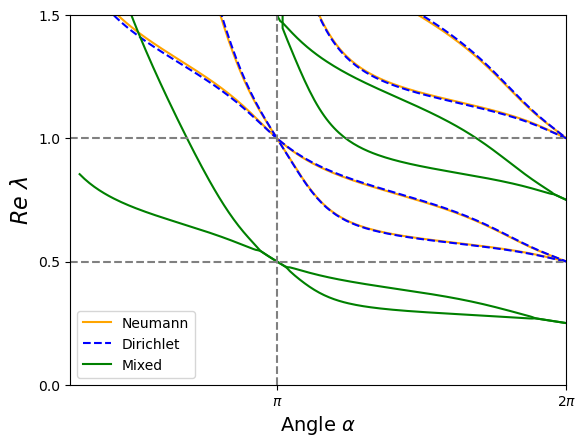

In [28]:
A_11 = np.array([[5, -0.7], [-0.7, 1.5]])
A_12 = np.array([[0.9,0.6 ], [0.6, -0.5]])
A_22 = np.array([[1, 0],[0, 1]])

V=getV(A_11,A_12,A_22)

alphas = np.linspace(1, 2 * pi - 0.001, 200)
results_d=[]
results_m=[]
results_n=[]

initial_guesses_d=[0.5+0.1j,1+0.1j]
initial_guesses_m=[0.25 + 0.1j,0.75+0.1j]
initial_guesses_n=[0.5 + 0.1j,1+0.1j]

for guess in initial_guesses_d:
    results_d.append(newton_series(V,alphas,det_dirichlet,guess=guess,pert=0.05,cap=2,tol=1e-4))
    results_d.append(newton_series(V,alphas,det_dirichlet,guess=guess,pert=-0.05,cap=2,tol=1e-4))

for guess in initial_guesses_m:
    results_m.append(newton_series(V,alphas,det_mixed,guess=guess,pert=0.05,cap=2,tol=1e-4))
    results_m.append(newton_series(V,alphas,det_mixed,guess=guess,pert=-0.05,cap=2,tol=1e-4))

for guess in initial_guesses_n:
    results_n.append(newton_series(V,alphas,det_neumann,guess=guess,pert=0.05,cap=2,tol=1e-4))
    results_n.append(newton_series(V,alphas,det_neumann,guess=guess,pert=-0.05,cap=2,tol=1e-4))

plot_lambdas_alphas(alphas,results_d=[x.real for x in results_d],results_m=[x.real for x in results_m],results_n=[x.real for x in results_n])

1.0

**Further ellipticity conditions**

In [30]:
def check_contractiveNeumann(V):
    C=V.real
    D=V.imag
    if max(abs(eig(inv(D)@C-C@inv(D))[0]))<2:
        print("V is contractive Neumann well-posed")
        return True
    else:
        print("V is not contractive Neumann well-posed")
        return False

## Section 5 - Matrix equations associated to the model problem

### Section 5.1 - Dirichlet boundary conditions

We want to numerically validate that we can bound the spectrum of $Z^{i\lambda_2}Z^{\lambda_1}(Z^{i\lambda_2})^* -\overline{Z}^{\lambda_1}$ within the complex plane for $|\Re \lambda|\leq 1$. For this we sample different symmetric complex matrices with positive imaginary part $Z$, $\lambda_1+\lambda_2$ and $|\lambda_1|\leq 1$.

In [32]:
#generate real symmetric matrix
def generate_RS(d):
    A = np.random.randn(d, d)
    return 0.5*(A+A.T)

#generate real positive definite matrix
def generate_RPD(d):
    A = generate_RS(d)
    return A@np.conj(A).T

#matrix exponential with principal logarithm
def mat_exp(M,lamb):
    B,Q=eig(M)
    return Q@np.diag(B**lamb)@inv(Q)

In [34]:
#this is for the scatter plot of eigenvalues
def scatter_plot(lists,title='plot', names=[],colors=[],xrange=[0,0],yrange=[0,0],grid=False,circle_r=0,s=5):
    if names==[]:
        names=['eigenvalues' for i in lists]
    if colors==[]:
        colors=['r' for i in lists]
    for i,lst in enumerate(lists):
        plt.scatter([x.real for x in lst], [x.imag for x in lst], color=colors[i], alpha=0.5, label=names[i],s=s)

    if grid==True:
        plt.axhline(y=0, color='grey', linestyle='--')
        plt.axvline(x=0, color='grey', linestyle='--')
    if circle_r!=0:
        T=np.linspace(0,2*pi,1000)
        C=[circle_r*np.cos(t) for t in T]
        S=[circle_r*np.sin(t) for t in T]
        plt.plot(C,S,color='grey')
    
    if xrange!=[0,0]:
        plt.xlim(xrange[0],xrange[1])
    if yrange!=[0,0]:
        plt.ylim(yrange[0],yrange[1])
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title(title)
    plt.legend()
    plt.show()

Number of eigenvalues x with sgn(lambda_1)*Im x<0:  0


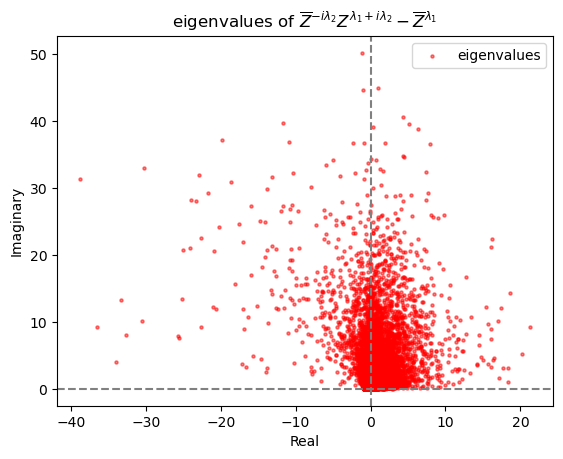

In [36]:
d=3 #dimension of matrices
sgn=1 #sets the sign of \lamdba_1. Change to -1,1.

lst=[]
counter=0 #counter if beta.imag has the wrong sign for beta an eigenvalue



for i in range(1,5000):
    l1=sgn*np.random.rand()
    l2=np.random.rand()-0.5   #short for lambda_1 and lambda_2 in lambda=lambda_1+i*lambda_2
    S=generate_RS(d)
    D=generate_RPD(d)
    Z=S+1j*D #generate Z
    M=mat_exp(np.conj(Z),-1j*l2)@mat_exp(Z,l1+1j*l2)-mat_exp(np.conj(Z),l1)
    B=eig(M)[0]
    for k in range(0,d):
        lst.append(np.round(B[k],decimals=6))
        if min(B).imag*sgn<0:
            counter+=1

print("Number of eigenvalues x with sgn(lambda_1)*Im x<0: ",counter)
scatter_plot([lst],title=r"eigenvalues of $\overline{Z}^{-i\lambda_2}Z^{\lambda_1+i\lambda_2} - \overline{Z}^{\lambda_1}$",colors=['r'],grid=True)


### Section 5.2 - Mixed boundary conditions

Similar to before we want to numerically validate that we can bound the eigenvalues of the expression $ M_1^* [A,B]M_1+iM_1^* M_2 $ for 
$M_1=Z^{i\lambda_2} Z^{\lambda_1}(Z^{i\lambda_2})^* -\overline{Z}^{\lambda_1}$ and $M_2=Z^{i\lambda_2} Z^{\lambda_1}(Z^{i\lambda_2})^* +\overline{Z}^{\lambda_1}$.

Number of eigenvalues x with sgn(lambda_1)*Re x<0:  0


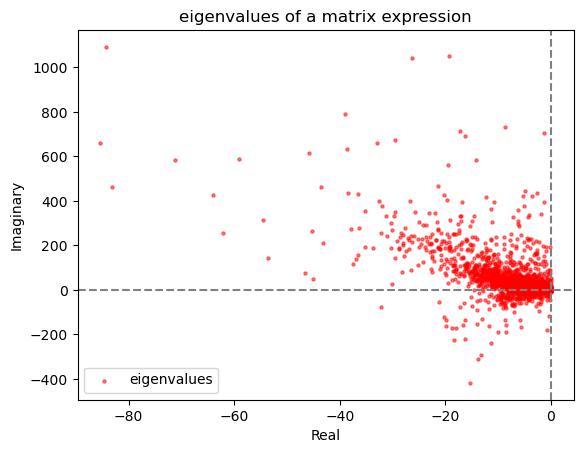

In [37]:
d=3
sgn=-1  #change to -1,1

lst=[]
counter=0

for i in range(1,5000):
    l1=sgn*np.random.rand()*0.5
    l2=np.random.rand()-0.5   #short for lambda_1 and lambda_2 in lambda=lambda_1+i*lambda_2
    S=generate_RS(d)
    D=generate_RPD(d)
    Z=S+1j*D #generate Z
    A=generate_RS(d)
    B=generate_RS(d)
    Z=S+1j*D
    M1=mat_exp(Z,1j*l2)@mat_exp(Z,l1)@np.conj(mat_exp(Z,1j*l2))-mat_exp(np.conj(Z),l1)
    M2=mat_exp(Z,1j*l2)@mat_exp(Z,l1)@np.conj(mat_exp(Z,1j*l2))+mat_exp(np.conj(Z),l1)
    mat=np.conj(M1).T@(A@B-B@A)@M1+1j*np.conj(M1).T@M2
    B=eig(mat )[0]
    for k in range(0,d):
        lst.append(np.round(B[k],decimals=6))
        if min(B).real*sgn<0:
            counter+=1

print("Number of eigenvalues x with sgn(lambda_1)*Re x<0: ",counter)
scatter_plot([lst],title=r"eigenvalues of a matrix expression",colors=['r'],grid=True)


## Section 6 - Summary and Comments

### Neumann boundary conditions

In [40]:
D=np.array([[2,1],[1,2]])
S=np.array([[0,0],[0,2]])

#S=np.array([[0,0.2],[0.2,2]]) #2.95
#D=np.array([[1,0.4],[0.4,5]])

V=(S+1j*np.eye(2))@D
check_contractiveNeumann(V)

def M(t):
    Vt=(S*t+1j*np.eye(2))@D
    return 2*1j*( (Vt-np.conj(Vt).T)@Vt@inv(Vt-np.conj(Vt).T) ).imag

print(M(0))
print(M(1))
eig(M(1))[0]

V is contractive Neumann well-posed
[[0.+4.j 0.+2.j]
 [0.+2.j 0.+4.j]]
[[0. +8.j 0. +8.j]
 [0.+12.j 0. +0.j]]


array([ 0.00000000e+00+14.58300524j, -3.08668481e-16 -6.58300524j])

V is contractive Neumann well-posed


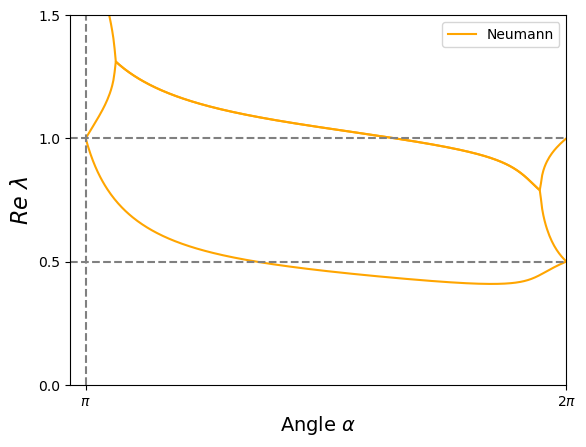

In [41]:
D=np.array([[2,1],[1,2]])
S=np.array([[0,0],[0,2]])

#S=np.array([[0,0.2],[0.2,2]]) #2.95
#D=np.array([[1,0.4],[0.4,5]])

V=(S+1j*np.eye(2))@D
check_contractiveNeumann(V)

alphas = np.linspace(pi, 2 * pi - 0.001, 400)

results_n=[]

initial_guesses_n=[0.5 + 0.1j,1+0.1j]

results_n.append(newton_series(V,alphas,det_neumann,guess=0.5+0.1j,pert=-0.03,cap=2,tol=1e-6))
results_n.append(newton_series(V,alphas,det_neumann,guess=0.5-0.1j,pert=+0.02+0.01j,cap=2,tol=1e-6))
results_n.append(newton_series(V,alphas,det_neumann,guess=1,pert=-0.02-0.01j,cap=2,tol=1e-6))

plot_lambdas_alphas(alphas,results_n=[x.real for x in results_n])

### Optimality of bounds

V is contractive Neumann well-posed


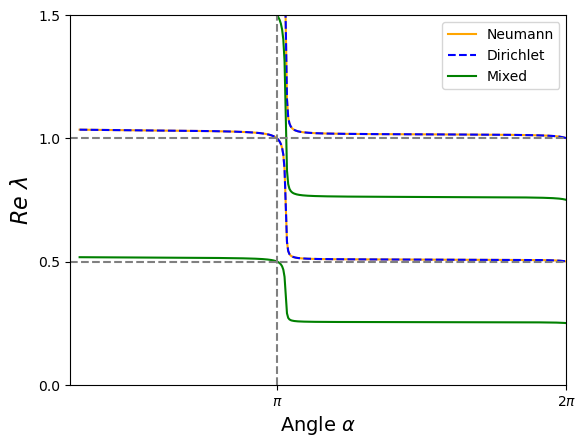

In [65]:
D=np.array([[1]])
S=np.array([[-10]])

V=(S+1j*np.eye(1))@D
check_contractiveNeumann(V)

alphas = np.linspace(1, 2 * pi - 0.001, 400)

results_d=[]
results_m=[]
results_n=[]

initial_guesses_d=[0.5+0.1j,1+0.1j]
initial_guesses_m=[0.25 + 0.1j,0.75+0.1j]
initial_guesses_n=[0.5 + 0.1j,1+0.1j]

for guess in initial_guesses_d:
    results_d.append(newton_series(V,alphas,det_dirichlet,guess=guess,pert=0.05,cap=2,tol=1e-4))

for guess in initial_guesses_m:
    results_m.append(newton_series(V,alphas,det_mixed,guess=guess,pert=0.05,cap=2,tol=1e-4))

for guess in initial_guesses_n:
    results_n.append(newton_series(V,alphas,det_neumann,guess=guess,pert=0.05,cap=2,tol=1e-4))

plot_lambdas_alphas(alphas,results_d=[x.real for x in results_d],results_m=[x.real for x in results_m],results_n=[x.real for x in results_n])